In [1]:
import os
import xarray as xr
from datetime import date
import json
from copy import copy


In [2]:
dt = date(2022,9,12)
area = 'sh'
outdir = '.'
indirs = None
climo = (1981, 2000)

In [3]:
# input monthly SIC files
fn_patt = 'ice_conc_{a:}_ease2-250_{c:}_{d:%Y%m}.nc'
fn_patt_src = {'cdr': 'cdr-v3p0', 'icdr': 'icdr-v3p0', 'icdrft': 'icdrft-v3p0'}

if indirs is None:
    inpdir = 'https://thredds.met.no/thredds/dodsC/metusers/thomasl/OSISAF_SICCDRv3_monthly_test/'
    # access through THREDDS/OpenDAP
    sources = {'cdr':inpdir,
              'icdr':inpdir,
              'icdrft':inpdir}
    jsond = json.dumps(sources, sort_keys=True, indent=4)
else:
    # load json file with path to input directories (if the daily SIC files are downloaded to a local disk)
    # an example json file (prepare_monthly_osisaf_sic_opendap.json) is provided to demonstrate the format
    #   expected for the json file (but the effect will be the same as setting indirs to None: read from
    #   THREDDS/opendap)
    with open(indirs, 'r') as f:
        sources = json.load(f)

In [4]:
def find_one_monthly_sic_file(dt, area):
    
    found_one_file = False
    for cdr in ('cdr', 'icdr', 'icdrft'):
        fn = fn_patt.format(a=area, d=dt, c=fn_patt_src[cdr])
        fn = os.path.join(sources[cdr],'{:%Y/}'.format(dt),fn)
        try:
            # this url exists, append it and move to next date
            ds = xr.open_dataset(fn)
            found_one_file = True
            return fn, cdr
        except OSError:
            # no valid file at this url, check the next rule
            pass
        
    # no file found. Add a warning (but we can continue)
    if not found_one_file:
        print("WARNING: could not find OSI SAF SIC v3 file for {} {}".format(area, dt))
        return None, None

def find_climo_monthly_sic_file(year_start, year_end, area, month):
    
    files = []
    for year in range(year_start, year_end+1):
        dt = date(year, month, 15)
        fn, src = find_one_monthly_sic_file(dt, area)
        if fn:
            files.append(fn)
    
    return files

fn, src = find_one_monthly_sic_file(dt, area)
climo_fns = find_climo_monthly_sic_file(climo[0], climo[1], area, dt.month)

print(fn)

print(climo_fns)

https://thredds.met.no/thredds/dodsC/metusers/thomasl/OSISAF_SICCDRv3_monthly_test/2022/ice_conc_sh_ease2-250_icdr-v3p0_202209.nc
['https://thredds.met.no/thredds/dodsC/metusers/thomasl/OSISAF_SICCDRv3_monthly_test/1981/ice_conc_sh_ease2-250_cdr-v3p0_198109.nc', 'https://thredds.met.no/thredds/dodsC/metusers/thomasl/OSISAF_SICCDRv3_monthly_test/1982/ice_conc_sh_ease2-250_cdr-v3p0_198209.nc', 'https://thredds.met.no/thredds/dodsC/metusers/thomasl/OSISAF_SICCDRv3_monthly_test/1983/ice_conc_sh_ease2-250_cdr-v3p0_198309.nc', 'https://thredds.met.no/thredds/dodsC/metusers/thomasl/OSISAF_SICCDRv3_monthly_test/1984/ice_conc_sh_ease2-250_cdr-v3p0_198409.nc', 'https://thredds.met.no/thredds/dodsC/metusers/thomasl/OSISAF_SICCDRv3_monthly_test/1985/ice_conc_sh_ease2-250_cdr-v3p0_198509.nc', 'https://thredds.met.no/thredds/dodsC/metusers/thomasl/OSISAF_SICCDRv3_monthly_test/1986/ice_conc_sh_ease2-250_cdr-v3p0_198609.nc', 'https://thredds.met.no/thredds/dodsC/metusers/thomasl/OSISAF_SICCDRv3_monthl

In [5]:
def reconstruct_sic(ds):
    ice_conc = ds['ice_conc'].to_masked_array()
    raw_ice_conc_values = ds['raw_ice_conc_values'].to_masked_array()
    status_flag = ds['status_flag'].to_masked_array().astype('short')

    # combine ice_conc with raw_ice_conc_values using the status_flag
    ice_conc[ice_conc==100] = raw_ice_conc_values[ice_conc==100]
    ice_conc[(status_flag & 4) == 4] = raw_ice_conc_values[(status_flag & 4) == 4]

    # re-enter "full" ice_conc into the xarray dataset
    ds['ice_conc'][:] = ice_conc
    return ds

In [6]:
# compute climatological average
climo_ds = xr.open_mfdataset(climo_fns)
climo_ds = reconstruct_sic(climo_ds)
climo_mean = climo_ds.mean(dim="time", keep_attrs=True)

In [7]:
# compute climatological anomaly
month_ds = xr.open_dataset(fn)
month_ds = reconstruct_sic(month_ds)

month_anomaly = month_ds - climo_mean
print(month_anomaly['ice_conc'].to_masked_array().min(), month_anomaly['ice_conc'].to_masked_array().max())

-87.74049999999998 63.0575


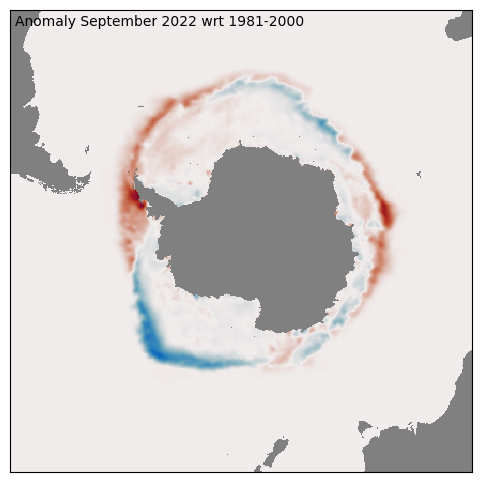

In [8]:
from matplotlib import pylab as plt
from cmocean import cm

cmap = copy(cm.balance_r)
cmap.set_bad('grey')

fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(month_anomaly['ice_conc'][0].to_masked_array(),
          interpolation='none', vmin=-100, vmax=+100, cmap=cmap)
ax.set_xticks([])
ax.set_yticks([])
ax.text(0.01,0.99,'Anomaly {:%B %Y} wrt {}-{}'.format(dt, *climo), va='top', transform=ax.transAxes)
plt.show()